In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import poppy
import threading as th
import time 
from IPython.display import clear_output
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi.scoobi as scoobi
import scoobi.utils as utils
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3

import lina
import lina.psds as psds

from magpyx.utils import ImageStream

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

wavelength = 633e-9


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [7]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', locam_channel='nsvcam', dm_channel='dm00disp01')
I.nlocam = 60

In [21]:
reload(scoobi)
scoobi.create_shmim('locam_ref_0', (I.nlocam, I.nlocam))
scoobi.create_shmim('locam_ref_delta', (I.nlocam, I.nlocam))

locam_ref_0_channel = ImageStream('locam_ref_0')
locam_ref_delta_channel = ImageStream('locam_ref_delta')

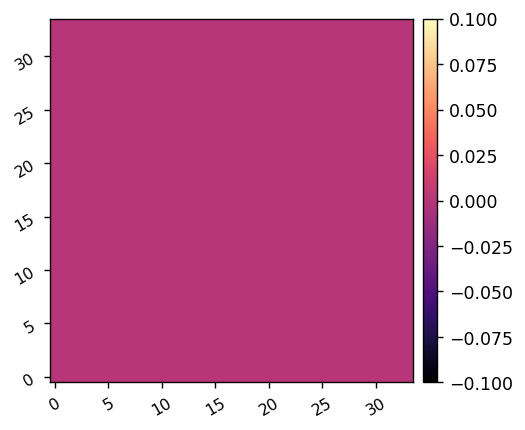

In [4]:
dh_channel = ImageStream('dm00disp05')
imshow1(dh_channel.grab_latest())

# Aquire LLOWFSC image

In [12]:
reload(scoobi)
scoobi.move_block_in(client0)

In [14]:
reload(scoobi)
scoobi.move_block_out(client0)

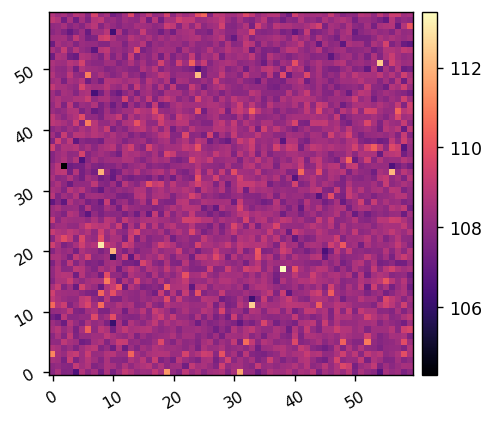

In [13]:
I.NLOCAM = 100
I.subtract_dark_locam = False
I.return_ni_locam = False
dark_frame = I.snap_locam()
I.df_locam = copy.copy(dark_frame)
imshow1(dark_frame)

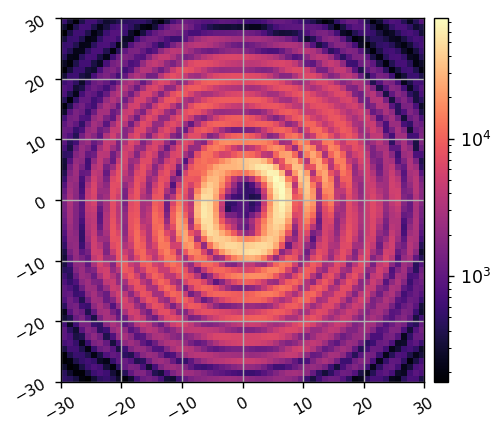

In [64]:
I.x_shift_locam = 0
I.y_shift_locam = 8
I.NLOCAM = 100

I.ref_locam_params = {
    'atten':0, 
    'texp':0.0001
}

I.att = 0
I.texp_locam = 0.0001
I.return_ni_locam = True
I.subtract_dark_locam = False

ref_im = I.snap_locam()
imshow1(ref_im, grid=True, pxscl=1, lognorm=True)

In [65]:
locam_ref_0_channel.write(ref_im)

# Perform LLOWFSC calibration

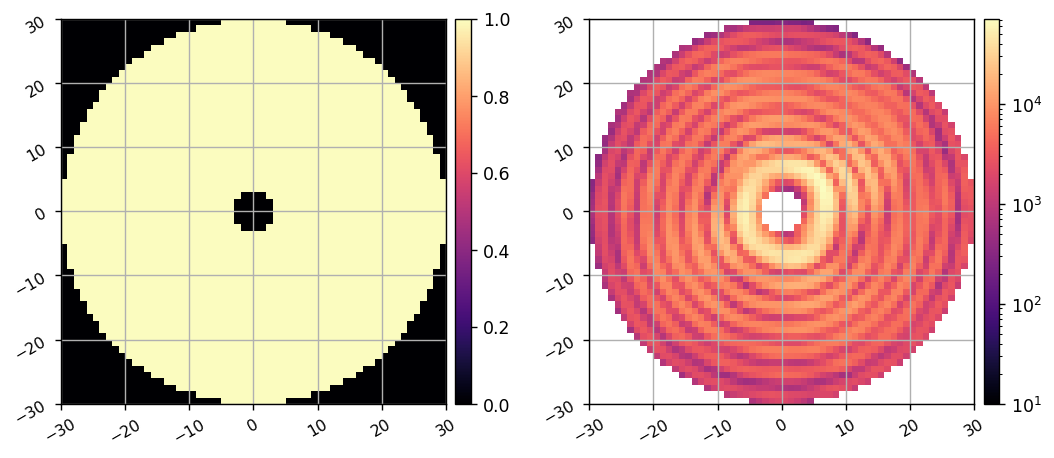

In [25]:
irad = 3
orad = 30
control_mask = ensure_np_array(lina.utils.create_annular_focal_plane_mask(I.nlocam, 1, irad, orad, edge=None, ))
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)
imshow2(control_mask, ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=1e1)

In [19]:
had_modes = ensure_np_array(lina.utils.create_hadamard_modes(xp.array(I.dm_mask)))
had_modal_matrix = had_modes.reshape(had_modes.shape[0], -1)


In [20]:
reload(lina.llowfsc)
I.zero_dm()
I.setattr('NLOCAM', 10)
I.dm_delay = 2*I.texp_locam
had_rm = lina.llowfsc.calibrate_without_fsm(I, control_mask, dm_modes=had_modes, amps=5e-9, plot=False)

In [33]:
reload(lina.llowfsc)
lina.llowfsc.update_locam_delta(had_rm, had_modal_matrix, control_mask, dh_channel, locam_ref_delta_channel,)

In [67]:
reload(scoobi)
reload(lina.llowfsc)
reload(lina.utils)

update_freq = 50

args = [had_rm, had_modal_matrix, control_mask, dh_channel, locam_ref_delta_channel]
update_ref_process = lina.utils.Process(1/update_freq, 
                                        lina.llowfsc.update_locam_delta, 
                                        args, # the args
                                        )

In [68]:
update_ref_process.start()

In [69]:
update_ref_process.cancel()

In [58]:
dh_channel.write(0.00*had_modes[500])

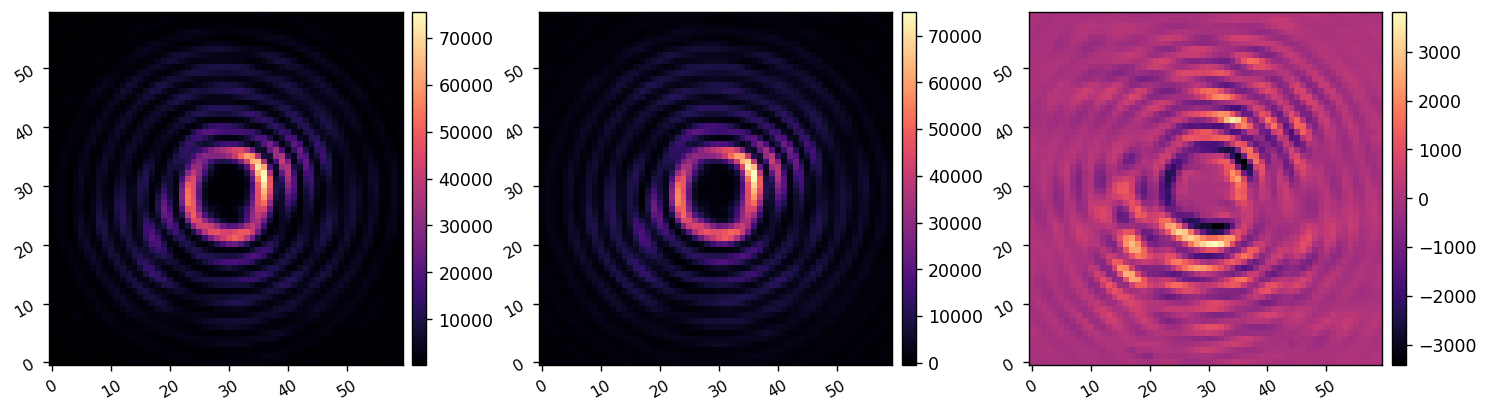

In [57]:
pred = locam_ref_0_channel.grab_latest() + locam_ref_delta_channel.grab_latest()
real = I.snap_locam()
diff = real - pred
imshow3(real, pred, diff)